In [ ]:
!pip install transformers datasets accelerate
!pip install evaluate
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


Phase 1: Establish the DistilBERT Baseline

In [ ]:
import torch
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
MODEL_NAME = "distilbert-base-uncased"
TASK = "sst2"
NUM_LABELS = 2
print(f"Loading dataset: {TASK}")
raw_datasets = load_dataset("glue", TASK)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding=True)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["validation"]
train_dataset.set_format("torch")
eval_dataset.set_format("torch")
metric = evaluate.load("glue", TASK)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
NUM_EPOCHS = 3
print(f"Loading base model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
training_args = TrainingArguments(
    output_dir="./baseline_results",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Loading dataset: sst2


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading base model: distilbert-base-uncased


/tmp/ipython-input-2162079969.py:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print(f"Loading base model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
print("Configuring Trainer...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
start_time = time.time()
trainer.train()
end_time = time.time()
training_time_min = (end_time - start_time) / 60
results = trainer.evaluate()
baseline_accuracy = results['eval_accuracy']
print("\n--- Baseline Results Summary ---")
print(f"Total Parameters: {model.num_parameters()}")
print(f"Validation Accuracy: {baseline_accuracy:.4f}")
baseline_results_single = [{
    'Method': 'Full Baseline Fine-Tuning',
    'Iteration': 1,
    'Total_Parameters': model.num_parameters(),
    'Trainable_Parameters': model.num_parameters(),
    'Validation_Accuracy': baseline_accuracy,
    'Training_Time_min': training_time_min,
}]
baseline_df_single = pd.DataFrame(baseline_results_single)
baseline_df_single.to_csv("baseline_training_results_single_run.csv", index=False)
print("\nBaseline results saved to baseline_training_results_single_run.csv")


--- Starting Baseline DistilBERT Fine-Tuning (ALL parameters trained) ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
print("\n--- Starting Baseline DistilBERT Fine-Tuning (ALL parameters trained) ---")
trainer.train()
results = trainer.evaluate()
baseline_accuracy = results['eval_accuracy']
print("\n--- Baseline Results Summary ---")
print(f"Total Parameters: {model.num_parameters()}")
print(f"Validation Accuracy: {baseline_accuracy:.4f}")
with open("baseline_results_summary.txt", "w") as f:
    f.write(f"Model: {MODEL_NAME}\n")
    f.write(f"Total Parameters: {model.num_parameters()}\n")
    f.write(f"Validation Accuracy: {baseline_accuracy:.4f}\n")


--- Starting Baseline DistilBERT Fine-Tuning (ALL parameters trained) ---


Epoch,Training Loss,Validation Loss,Accuracy
1,0.184800,0.261082,0.905963
2,0.126600,0.354080,0.907110
3,0.087300,0.406616,0.909404



--- Baseline Results Summary ---
Total Parameters: 66955010
Validation Accuracy: 0.9094


In [ ]:
import torch
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
MODEL_NAME = "distilbert-base-uncased"
TASK = "sst2"
NUM_LABELS = 2
LEARNING_RATE = 5e-4
BATCH_SIZE = 16
NUM_EPOCHS = 3
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.1
TARGET_MODULES = ["q_lin", "v_lin", "out_lin"]
LORA_CONFIG = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_CLS,
    target_modules=TARGET_MODULES,
)

In [ ]:
metric = evaluate.load("glue", TASK)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
import torch
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
MODEL_NAME = "distilbert-base-uncased"
TASK = "sst2"
NUM_LABELS = 2
MANUAL_SEED = 42
LEARNING_RATE = 5e-4
BATCH_SIZE = 16
NUM_EPOCHS = 3
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.1
TARGET_MODULES = ["q_lin", "v_lin", "out_lin"]
LORA_CONFIG = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_CLS,
    target_modules=TARGET_MODULES,
)
print(f"Loading dataset: {TASK}")
raw_datasets = load_dataset("glue", TASK)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding=True)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])
train_dataset = tokenized_datasets["train"].shuffle(seed=MANUAL_SEED)
eval_dataset = tokenized_datasets["validation"]
train_dataset.set_format("torch")
eval_dataset.set_format("torch")
metric = evaluate.load("glue", TASK)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)
print(f"\nLoading base model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
print("\n--- Applying Mandatory Parameter Freeze ---")
for name, param in model.named_parameters():
    param.requires_grad = False
trainable_count_before_peft = model.num_parameters(only_trainable=True)
print(f"Trainable parameters after manual freeze (should be ~0): {trainable_count_before_peft}")
lora_model = get_peft_model(model, LORA_CONFIG)
print("\n--- Trainable Parameters After LoRA Injection ---")
lora_model.print_trainable_parameters()
print(f"Total Model Parameters: {model.num_parameters()}")
training_args = TrainingArguments(
    output_dir="./lora_results_final_fix",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    seed=MANUAL_SEED,
)
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
print("\n--- Starting LoRA Fine-Tuning (Mandatory Freeze Applied) ---")
trainer.train()
results = trainer.evaluate()
lora_accuracy = results['eval_accuracy']
print("\n--- LoRA Results Summary (Corrected) ---")
print(f"Total Model Parameters: {model.num_parameters()}")
print(f"Trainable LoRA Parameters: {lora_model.num_parameters(only_trainable=True)}")
print(f"Validation Accuracy: {lora_accuracy:.4f}")
with open("lora_results_summary_final.txt", "w") as f:
    f.write(f"Model: {MODEL_NAME} with LoRA (r={LORA_R}, modules={TARGET_MODULES}, lr={LEARNING_RATE})\n")
    f.write(f"Trainable LoRA Parameters: {lora_model.num_parameters(only_trainable=True)}\n")
    f.write(f"Validation Accuracy: {lora_accuracy:.4f}\n")
print(f"\nResults saved to lora_results_summary_final.txt.")

Loading dataset: sst2


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loading base model: distilbert-base-uncased

--- Applying Mandatory Parameter Freeze ---
Trainable parameters after manual freeze (should be ~0): 0

--- Trainable Parameters After LoRA Injection ---
trainable params: 1,034,498 || all params: 67,989,508 || trainable%: 1.5216
Total Model Parameters: 67989508


/tmp/ipython-input-3220716867.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Starting LoRA Fine-Tuning (Mandatory Freeze Applied) ---


Epoch,Training Loss,Validation Loss,Accuracy
1,0.225500,0.319693,0.878440
2,0.172900,0.321445,0.896789
3,0.124600,0.379389,0.900229



--- LoRA Results Summary (Corrected) ---
Total Model Parameters: 67989508
Trainable LoRA Parameters: 1034498
Validation Accuracy: 0.9002

Results saved to lora_results_summary_final.txt.



--- Efficiency Summary ---
Baseline Time: 21.98 min | Params: 66.96M
LoRA Time:     14.23 min | Params: 1.034M
-----------------------------------
LoRA reduced training time by: 7.75 minutes.


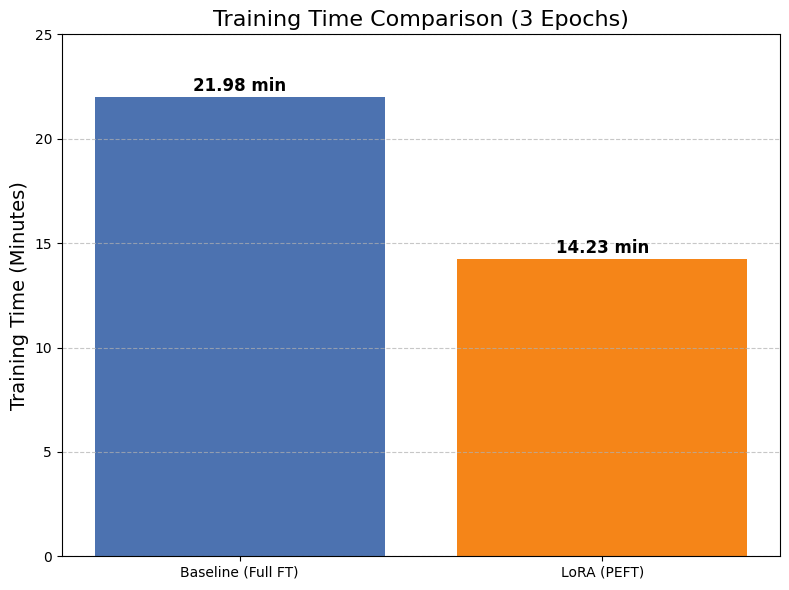

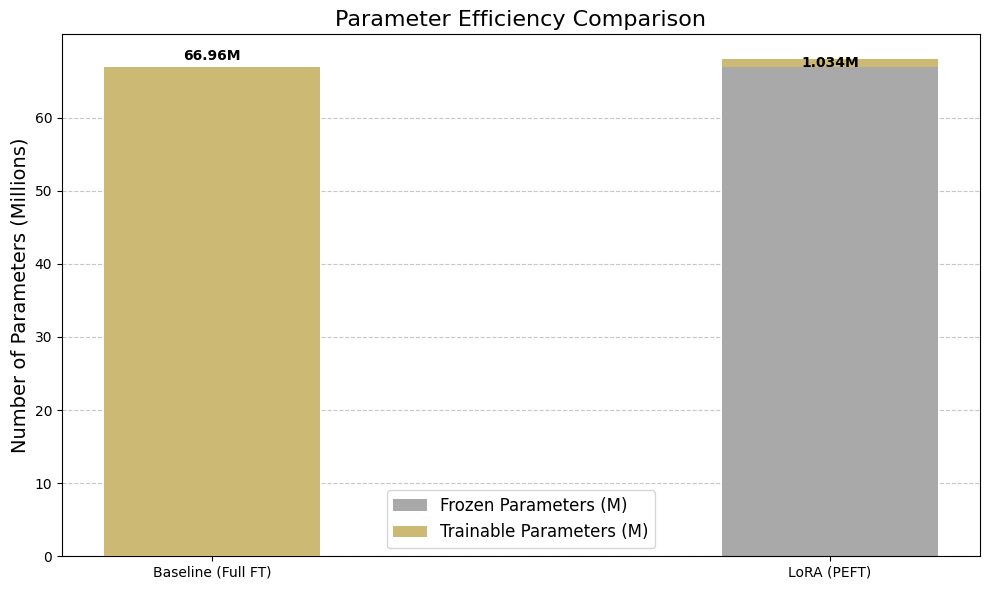


Two comparison plots have been generated: Training Time and Parameter Efficiency.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
TOTAL_PARAMS = 67989508
BASELINE_TRAINABLE = 66955010
LORA_TRAINABLE = 1034498
BASELINE_ACCURACY = 0.9094
LORA_ACCURACY = 0.9002
BASELINE_TIME_MINUTES = (21 * 60 + 59) / 60
LORA_TIME_MINUTES = (14 * 60 + 14) / 60
def plot_time_comparison():
    methods = ['Baseline (Full FT)', 'LoRA (PEFT)']
    times = [BASELINE_TIME_MINUTES, LORA_TIME_MINUTES]
    plt.figure(figsize=(8, 6))
    bars = plt.bar(methods, times, color=['#4c72b0', '#f58518'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f} min', ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.title('Training Time Comparison (3 Epochs)', fontsize=16)
    plt.ylabel('Training Time (Minutes)', fontsize=14)
    plt.ylim(0, 25)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
def plot_parameter_comparison():
    methods = ['Baseline (Full FT)', 'LoRA (PEFT)']
    trainable_counts_M = [BASELINE_TRAINABLE / 1e6, LORA_TRAINABLE / 1e6]
    non_trainable_counts_M = [0, (TOTAL_PARAMS - LORA_TRAINABLE) / 1e6]
    x = np.arange(len(methods))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, non_trainable_counts_M, width, label='Frozen Parameters (M)', color='#a9a9a9', zorder=2)
    rects2 = ax.bar(x, trainable_counts_M, width, bottom=non_trainable_counts_M,
                    label='Trainable Parameters (M)', color='#ccb974', zorder=3)
    ax.text(rects2[0].get_x() + rects2[0].get_width() / 2, trainable_counts_M[0] + 0.5,
            f'{trainable_counts_M[0]:.2f}M', ha='center', va='bottom', fontweight='bold', color='black')
    ax.text(rects2[1].get_x() + rects2[1].get_width() / 2, rects2[1].get_y() + rects2[1].get_height() / 2,
            f'{trainable_counts_M[1]:.3f}M', ha='center', va='center', color='black', fontweight='bold', fontsize=10)
    ax.set_title('Parameter Efficiency Comparison', fontsize=16)
    ax.set_ylabel('Number of Parameters (Millions)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.set_yticks(np.arange(0, 70, 10))
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    print(f"\n--- Efficiency Summary ---")
    print(f"Baseline Time: {BASELINE_TIME_MINUTES:.2f} min | Params: {BASELINE_TRAINABLE / 1e6:.2f}M")
    print(f"LoRA Time:     {LORA_TIME_MINUTES:.2f} min | Params: {LORA_TRAINABLE / 1e6:.3f}M")
    print("-" * 35)
    print(f"LoRA reduced training time by: {(BASELINE_TIME_MINUTES - LORA_TIME_MINUTES):.2f} minutes.")
    plot_time_comparison()
    plot_parameter_comparison()
    print("\nTwo comparison plots have been generated: Training Time and Parameter Efficiency.")